# <font style="color:rgb(50,120,229)"> EE5/7382 – Fundamentals of Computer Vision - Final Examination
</font>

##### <font color="yellow">Preamble</font>

In [1]:
import cv2 as cv                    # Computer Vision
import matplotlib.pyplot as plt     # Plotting
import numpy as np                  # Numerics
import os

##### <font color="yellow">Helper function to read ToF sensor data</font>

In [2]:
def read_PCL(sz,fileName):
    """
    Function accepts two arguments
        sz specifies the number of rows & columns in the ToF sensor
        fileName specifies the path to the filename
    """
    
    # The data is stored as an array of float's
    # Each pixel has 4 floats (X,Y,Z,I)
    # Each frames has 320 x 240 such pixels

    # Number of bytes in file
    numBytes_in_file = os.path.getsize(fileName)
    
    # Number of bytes per pixel
    f = np.zeros(1,dtype='float32') # 4 bytes
    numAttributes_Per_Pixel = int(4) # X,Y,Z,I
    numBytes_Per_Pixel = numAttributes_Per_Pixel * 4

    # Number of bytes per frame
    numPixels_Per_Frame = int(sz[0]*sz[1]);
    numBytes_Per_Frame = numPixels_Per_Frame * numBytes_Per_Pixel
    # print(numBytes_Per_Frame)

    # Number of frames in file
    numFrames = int(numBytes_in_file/(numPixels_Per_Frame * numBytes_Per_Pixel))
    print('Detected {} frames in file'.format(numFrames))    
    
    # Allocate storage for data from ToF camera
    # arr = np.zeros(numPixels_Per_Frame * numAttributes_Per_Pixel, numFrames,'float32')  

    # fid_pcl = open(filename, 'rb', 0) # no buffering
    # for nn in range(numFrames)
    #     # arr(:,nn) = fread(fid_pcl, numPixels_Per_Frame * numAttributes_Per_Pixel, 'float' );
    # end
    # fid_pcl.close()

    with open(fileName, 'rb') as file:
        arr2D = np.fromfile(file, dtype=np.single).reshape(numFrames,numPixels_Per_Frame*numAttributes_Per_Pixel)
        arr2D = np.transpose(arr2D)

        print('Median filtering {} frames to reduce noise'.format(numFrames))    
        # Median filtering to mitigate noise
        arr1D = np.median(arr2D,1)
        nelm = arr1D.size
        """
        Read Point Cloud (Xw,Yw,Zw) from file
            Every 4th element beginning with 1st element corresponds to Xw
            Every 4th element beginning with 2nd element corresponds to Yw
            Every 4th element beginning with 3rd element corresponds to Zw
            Every 4th element beginning with 4rd element corresponds to intensity information I
        """        
        X = arr1D[range(0,nelm,4)].reshape(sz[0],sz[1])  
        Y = arr1D[range(1,nelm,4)].reshape(sz[0],sz[1])
        Z = arr1D[range(2,nelm,4)].reshape(sz[0],sz[1])         
        """
        WARNING: Depth Map is subject to geometric distortion
        Compensate using camera intrinsics undistort(), prior to dimensioning
        """
        Depth_Map_Distorted = Z     
        """
        WARNING: Intensity Image is subject to geometric distortion
        Compensate using camera intrinsics undistort(), prior to dimensioning
        """
        Intensity_Image_Distorted = arr1D[range(3,nelm,4)].reshape(sz[0],sz[1])
    #
    return X, Y, Z, Intensity_Image_Distorted, Depth_Map_Distorted


##### <font color="yellow">Read data from ToF sensor</font>

Detected 200 frames in file
Median filtering 200 frames to reduce noise


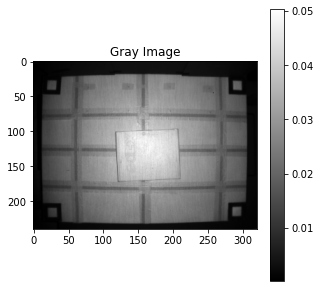

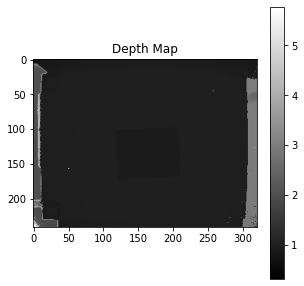

In [3]:
"""
depthImg reports the depth of each pixel in physical units
grayImg reports the monochrome intensity image acquired by the camera
Xw reports the world coordinates of the 
"""
[Xw,Yw,Zw,grayImg,depthMap] = read_PCL([240,320],'FedEx_Box2_PCL_300.txt')

plt.figure(figsize=[5,5])
plt.imshow( grayImg, cmap='gray' )
plt.title('Gray Image')
plt.colorbar()

plt.figure(figsize=[5,5])
plt.imshow( depthMap, cmap='gray' )
plt.title('Depth Map')
plt.colorbar()

##### <font color="yellow">Your approach to dimensioning the box</font>

Text(0.5, 1.0, 'Frequently occuring depths in Depth Map')

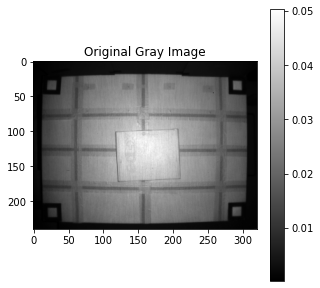

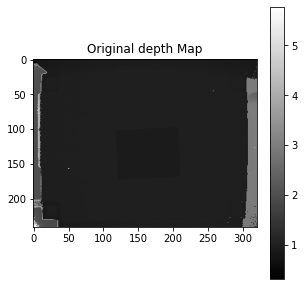

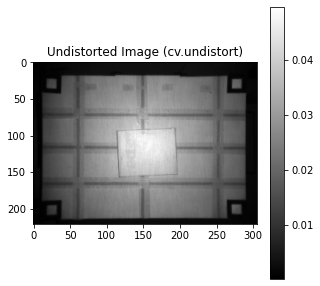

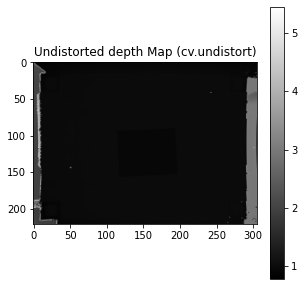

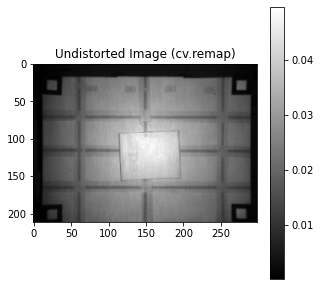

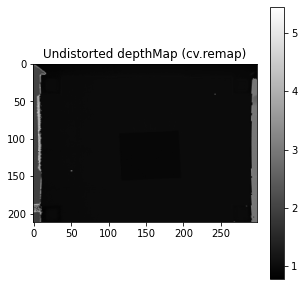

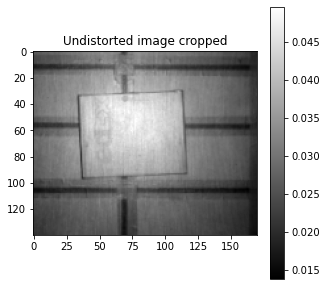

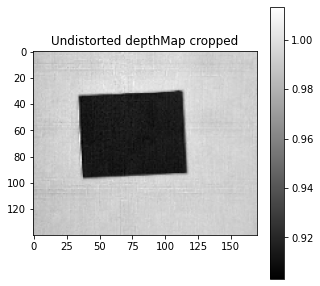

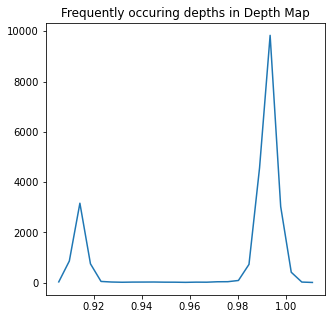

In [4]:
# Your code goes here
# Exemplar code to compute histogram
# WARNING: This is only for illustrative purposes
# You will have to undistort the depth map, and crop out a ROI before you attempt to compute the histogram
mtx=np.array([[225.607,0,158.205],[0,224.547,118.488],[0,0,1]])
k1, k2, p1, p2, k3 = -0.202793, 0.176023, 0.000450451, -0.000485368, -0.0887613
dist = np.array([k1, k2, p1, p2, k3])
h,  w = grayImg.shape[:2]#the w,h in both gray and depthmap images are the same
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# Undistort the image using cv.undistort
undistorted_img = cv.undistort(grayImg, mtx, dist, None, newcameramtx)
x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]
cv.imwrite('calibresult.png', undistorted_img )

undistorted_depthMap = cv.undistort(depthMap, mtx, dist, None, newcameramtx)
x, y, w, h = roi
undistorted_depthMap = undistorted_depthMap[y:y+h, x:x+w]
cv.imwrite('calibresultdepthMap.png', undistorted_depthMap )

# Use cv.initUndistortRectifyMap and cv.remap for undistortion 
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
undistorted_img_remap = cv.remap(grayImg, mapx, mapy, cv.INTER_LINEAR)
x, y, w, h = roi
undistorted_img_remap = undistorted_img_remap[y:y+h, x:x+w]
cv.imwrite('calibresult.png', undistorted_img_remap)

undistorted_depthMap_remap = cv.remap(depthMap, mapx, mapy, cv.INTER_LINEAR)
x, y, w, h = roi
undistorted_depthMap_remap = undistorted_depthMap_remap[y:y+h, x:x+w]
cv.imwrite('calibresultdepthMap.png', undistorted_depthMap_remap)
# Display the results
plt.figure(figsize=[5, 5])
plt.imshow(grayImg, cmap='gray')
plt.title('Original Gray Image')
plt.colorbar()

plt.figure(figsize=[5, 5])
plt.imshow(depthMap, cmap='gray')
plt.title('Original depth Map')
plt.colorbar()

plt.figure(figsize=[5, 5])
plt.imshow(undistorted_img, cmap='gray')
plt.title('Undistorted Image (cv.undistort)')
plt.colorbar()

plt.figure(figsize=[5, 5])
plt.imshow(undistorted_depthMap, cmap='gray')
plt.title('Undistorted depth Map (cv.undistort)')
plt.colorbar()

plt.figure(figsize=[5, 5])
plt.imshow(undistorted_img_remap, cmap='gray')
plt.title('Undistorted Image (cv.remap)')
plt.colorbar()

plt.figure(figsize=[5, 5])
plt.imshow(undistorted_depthMap_remap, cmap='gray')
plt.title('Undistorted depthMap (cv.remap)')
plt.colorbar()

cropped_img = undistorted_img_remap[60:200, 80:250]
plt.figure(figsize=[5, 5])
plt.imshow(cropped_img, cmap='gray')
plt.title('Undistorted image cropped')
plt.colorbar()

cropped_depthMap = undistorted_depthMap_remap[60:200, 80:250]
plt.figure(figsize=[5, 5])
plt.imshow(cropped_depthMap, cmap='gray')
plt.title('Undistorted depthMap cropped')
plt.colorbar()
numBins = 25
[freq,binEdges] = np.histogram(np.ravel(cropped_depthMap),numBins)

binCenters = 0.5*binEdges[0:-1] + 0.5*binEdges[1::]
plt.figure(figsize=[5, 5])
plt.plot(binCenters,freq)
plt.title('Frequently occuring depths in Depth Map')

In [5]:
undistorted_Xw = cv.undistort(Xw, mtx, dist, None, newcameramtx)
x, y, w, h = roi
undistorted_Xw = undistorted_Xw[y:y+h, x:x+w]
cv.imwrite('calibresultXw.png', undistorted_Xw )
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
undistorted_Xw_remap = cv.remap(Xw, mapx, mapy, cv.INTER_LINEAR)
x, y, w, h = roi
undistorted_Xw_remap = undistorted_Xw_remap[y:y+h, x:x+w]
cv.imwrite('calibresultXw.png', undistorted_Xw_remap)

True

In [6]:
undistorted_Yw = cv.undistort(Yw, mtx, dist, None, newcameramtx)
x, y, w, h = roi
undistorted_Yw = undistorted_Yw[y:y+h, x:x+w]
cv.imwrite('calibresultYw.png', undistorted_Yw )
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
undistorted_Yw_remap = cv.remap(Yw, mapx, mapy, cv.INTER_LINEAR)
x, y, w, h = roi
undistorted_Yw_remap = undistorted_Yw_remap[y:y+h, x:x+w]
cv.imwrite('calibresultYw.png', undistorted_Yw_remap)

True

In [7]:
undistorted_Zw = cv.undistort(Zw, mtx, dist, None, newcameramtx)
x, y, w, h = roi
undistorted_Zw = undistorted_Zw[y:y+h, x:x+w]
cv.imwrite('calibresultZw.png', undistorted_Zw )
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
undistorted_Zw_remap = cv.remap(Zw, mapx, mapy, cv.INTER_LINEAR)
x, y, w, h = roi
undistorted_Zw_remap = undistorted_Zw_remap[y:y+h, x:x+w]
cv.imwrite('calibresultZw.png', undistorted_Zw_remap)

True

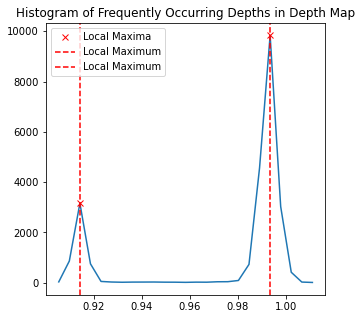

Local Maxima Depths: [0.9142493  0.99339926]


In [8]:
from scipy.signal import find_peaks

# Your code for undistortion and cropping...

# Display the histogram of the cropped depth map
numBins = 25
freq, binEdges = np.histogram(np.ravel(cropped_depthMap), numBins)

binCenters = 0.5 * binEdges[0:-1] + 0.5 * binEdges[1::]
plt.figure(figsize=[5, 5])
plt.plot(binCenters, freq)
plt.title('Histogram of Frequently Occurring Depths in Depth Map')

# Find local maxima in the histogram
peaks, _ = find_peaks(freq>3000)

# Display the local maxima
plt.plot(binCenters[peaks], freq[peaks], 'x', color='r', label='Local Maxima')
plt.legend()

# Get the depths corresponding to local maxima
local_maxima_depths = binCenters[peaks]

# Display the local maxima depths
for depth in local_maxima_depths:
    plt.axvline(x=depth, color='r', linestyle='--', label='Local Maximum')

plt.legend()
plt.show()

# Print the local maxima depths
print("Local Maxima Depths:", local_maxima_depths)

In [9]:
print("the hight of box in meter is ",abs(local_maxima_depths[1]-local_maxima_depths[0]))

the hight of box in meter is  0.07914996


Corner at (113, 31)
Corner at (112, 32)
Corner at (35, 35)
Corner at (36, 35)
Corner at (115, 92)
Corner at (116, 92)
Corner at (39, 95)
Corner at (39, 96)


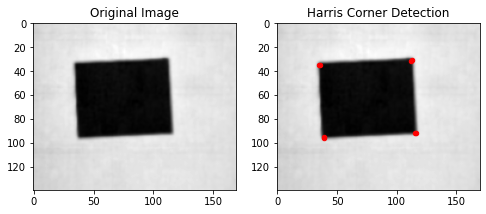

In [10]:
# Assuming depth_map_smoothed is your processed image
depth_map_smoothed = cv.GaussianBlur(cropped_depthMap, (7, 7), 1)

# Normalize the depth map values to the range [0, 255]
normalized_depth_map = cv.normalize(depth_map_smoothed, None, 0, 255, cv.NORM_MINMAX)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Load the undistorted and cropped grayscale image
img = normalized_depth_map
# Convert the image to grayscale


# Harris Corner Detection
dst = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.04)

# Threshold for an optimal value, it may vary depending on the image
threshold = 0.2 * dst.max()

# Create an image copy to draw corners on
corner_img = np.copy(img)

# Draw corners on the image

corner_img[dst > threshold] =255
corner_coordinates = np.argwhere(dst > threshold)

# Print the corner coordinates
for corner in corner_coordinates:
    print(f"Corner at ({corner[1]}, {corner[0]})")

# Display the results
plt.figure(figsize=[8, 8])
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(corner_img, cmap='gray'), plt.title('Harris Corner Detection'),
plt.scatter(corner_coordinates[:, 1], corner_coordinates[:, 0], c='red', marker='o', s=20)  # Add red points


plt.show()



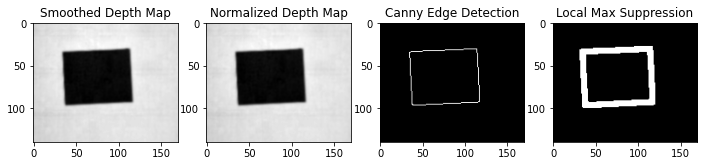

In [11]:
import cv2

# Assuming depth_map_smoothed is your processed image
depth_map_smoothed = cv2.GaussianBlur(cropped_depthMap, (7, 7), 1)

# Normalize the depth map values to the range [0, 255]
normalized_depth_map = cv2.normalize(depth_map_smoothed, None, 0, 255, cv2.NORM_MINMAX)

# Convert the depth map to an 8-bit unsigned integer image
depth_map_uint8 = np.uint8(normalized_depth_map)

# Perform Canny edge detection
edges = cv2.Canny(depth_map_uint8, 220, 255)

# Perform Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=150)

# Create an empty image for the lines
line_image = np.zeros_like(edges)

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 )
        y1 = int(y0 )
        x2 = int(x0 )
        y2 = int(y0 )
        cv2.line(line_image, (x1, y1), (x2, y2), 255, 1)

# Dilate the edges to strengthen and extend them
dilated_edges = cv2.dilate(edges, None, iterations=3)

# Combine the dilated edges with the Hough lines
combined_edges = cv2.bitwise_or(dilated_edges, line_image)

# Perform local maximum suppression
local_max_mask = (combined_edges == cv2.dilate(combined_edges, None, iterations=1))

# Apply the local maximum mask to suppress non-maximum values
local_max_suppressed_edges = combined_edges.copy()
local_max_suppressed_edges[~local_max_mask] = 0

# Display the results
plt.figure(figsize=[15, 5])

plt.subplot(1, 5, 1)
plt.imshow(depth_map_smoothed, cmap='gray')
plt.title('Smoothed Depth Map')

plt.subplot(1, 5, 2)
plt.imshow(normalized_depth_map, cmap='gray')
plt.title('Normalized Depth Map')

plt.subplot(1, 5, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')

plt.subplot(1, 5, 4)
plt.imshow(local_max_suppressed_edges, cmap='gray')
plt.title('Local Max Suppression')

plt.show()


In [12]:
nonzero_indices = np.nonzero(local_max_suppressed_edges)

# Extract row and column indices separately
row_indices, col_indices = nonzero_indices

# Display the indices
for i in range(len(row_indices)):
    print(f"Non-zero pixel at ({row_indices[i]}, {col_indices[i]})")

Non-zero pixel at (27, 95)
Non-zero pixel at (27, 96)
Non-zero pixel at (27, 97)
Non-zero pixel at (27, 98)
Non-zero pixel at (27, 99)
Non-zero pixel at (27, 100)
Non-zero pixel at (27, 101)
Non-zero pixel at (27, 102)
Non-zero pixel at (27, 103)
Non-zero pixel at (27, 104)
Non-zero pixel at (27, 105)
Non-zero pixel at (27, 106)
Non-zero pixel at (27, 107)
Non-zero pixel at (27, 108)
Non-zero pixel at (27, 109)
Non-zero pixel at (27, 110)
Non-zero pixel at (27, 111)
Non-zero pixel at (27, 112)
Non-zero pixel at (27, 113)
Non-zero pixel at (27, 114)
Non-zero pixel at (27, 115)
Non-zero pixel at (27, 116)
Non-zero pixel at (28, 73)
Non-zero pixel at (28, 74)
Non-zero pixel at (28, 75)
Non-zero pixel at (28, 76)
Non-zero pixel at (28, 77)
Non-zero pixel at (28, 78)
Non-zero pixel at (28, 79)
Non-zero pixel at (28, 80)
Non-zero pixel at (28, 81)
Non-zero pixel at (28, 82)
Non-zero pixel at (28, 83)
Non-zero pixel at (28, 84)
Non-zero pixel at (28, 85)
Non-zero pixel at (28, 86)
Non-zero pi

In [13]:

depth = local_maxima_depths[0]  
camera_matrix = newcameramtx
# Invert the camera matrix
world_coordinates=[]
world_coordinates_homo=[]
inv_camera_matrix = np.linalg.inv(camera_matrix)
for (y,x) in corner_coordinates:
    
    homogeneous_coords = np.array([x, y, 1])

    # Perform the conversion
    real_world_coords = np.dot(inv_camera_matrix, homogeneous_coords) * depth

    # Extract X, Y, Z coordinates
    X, Y, Z = real_world_coords
    #print(f"Real-world coordinates: X={X}, Y={Y}, Z={Z}")
    world_coordinates.append([X,Y,Z])
    world_coordinates_homo.append([X,Y])




In [14]:
world_coordinates

[[-0.2024410215391773, -0.4043965911890774, 0.9142493009567261],
 [-0.20704777999676527, -0.39974834859118147, 0.9142493009567261],
 [-0.5617681812310341, -0.3858036207974935, 0.9142493009567261],
 [-0.5571614227734462, -0.3858036207974935, 0.9142493009567261],
 [-0.1932275046240015, -0.12085379271742266, 0.9142493009567261],
 [-0.18862074616641364, -0.12085379271742266, 0.9142493009567261],
 [-0.5433411474006825, -0.1069090649237347, 0.9142493009567261],
 [-0.5433411474006825, -0.10226082232583875, 0.9142493009567261]]

In [15]:
world_coordinates_homo

[[-0.2024410215391773, -0.4043965911890774],
 [-0.20704777999676527, -0.39974834859118147],
 [-0.5617681812310341, -0.3858036207974935],
 [-0.5571614227734462, -0.3858036207974935],
 [-0.1932275046240015, -0.12085379271742266],
 [-0.18862074616641364, -0.12085379271742266],
 [-0.5433411474006825, -0.1069090649237347],
 [-0.5433411474006825, -0.10226082232583875]]

In [16]:
from scipy.spatial import distance_matrix
distances_for_corners=distance_matrix(world_coordinates_homo, world_coordinates_homo)

In [17]:
distances_for_corners

array([[0.        , 0.00654434, 0.35980787, 0.35520735, 0.28369245,
        0.28387941, 0.4524508 , 0.45552049],
       [0.00654434, 0.        , 0.35499439, 0.35039124, 0.27923677,
        0.27950265, 0.44592384, 0.44899004],
       [0.35980787, 0.35499439, 0.        , 0.00460676, 0.45389497,
        0.45764333, 0.27950265, 0.28414094],
       [0.35520735, 0.35039124, 0.00460676, 0.        , 0.45016254,
        0.45389497, 0.27923677, 0.28387941],
       [0.28369245, 0.27923677, 0.45389497, 0.45016254, 0.        ,
        0.00460676, 0.35039124, 0.35060699],
       [0.28387941, 0.27950265, 0.45764333, 0.45389497, 0.00460676,
        0.        , 0.35499439, 0.35520735],
       [0.4524508 , 0.44592384, 0.27950265, 0.27923677, 0.35039124,
        0.35499439, 0.        , 0.00464824],
       [0.45552049, 0.44899004, 0.28414094, 0.28387941, 0.35060699,
        0.35520735, 0.00464824, 0.        ]])

In [18]:
flattened_distances = distances_for_corners.flatten()
flattened_distances

array([0.        , 0.00654434, 0.35980787, 0.35520735, 0.28369245,
       0.28387941, 0.4524508 , 0.45552049, 0.00654434, 0.        ,
       0.35499439, 0.35039124, 0.27923677, 0.27950265, 0.44592384,
       0.44899004, 0.35980787, 0.35499439, 0.        , 0.00460676,
       0.45389497, 0.45764333, 0.27950265, 0.28414094, 0.35520735,
       0.35039124, 0.00460676, 0.        , 0.45016254, 0.45389497,
       0.27923677, 0.28387941, 0.28369245, 0.27923677, 0.45389497,
       0.45016254, 0.        , 0.00460676, 0.35039124, 0.35060699,
       0.28387941, 0.27950265, 0.45764333, 0.45389497, 0.00460676,
       0.        , 0.35499439, 0.35520735, 0.4524508 , 0.44592384,
       0.27950265, 0.27923677, 0.35039124, 0.35499439, 0.        ,
       0.00464824, 0.45552049, 0.44899004, 0.28414094, 0.28387941,
       0.35060699, 0.35520735, 0.00464824, 0.        ])

In [19]:
flattened_distances[flattened_distances < 0.01] = 0
flattened_distances

array([0.        , 0.        , 0.35980787, 0.35520735, 0.28369245,
       0.28387941, 0.4524508 , 0.45552049, 0.        , 0.        ,
       0.35499439, 0.35039124, 0.27923677, 0.27950265, 0.44592384,
       0.44899004, 0.35980787, 0.35499439, 0.        , 0.        ,
       0.45389497, 0.45764333, 0.27950265, 0.28414094, 0.35520735,
       0.35039124, 0.        , 0.        , 0.45016254, 0.45389497,
       0.27923677, 0.28387941, 0.28369245, 0.27923677, 0.45389497,
       0.45016254, 0.        , 0.        , 0.35039124, 0.35060699,
       0.28387941, 0.27950265, 0.45764333, 0.45389497, 0.        ,
       0.        , 0.35499439, 0.35520735, 0.4524508 , 0.44592384,
       0.27950265, 0.27923677, 0.35039124, 0.35499439, 0.        ,
       0.        , 0.45552049, 0.44899004, 0.28414094, 0.28387941,
       0.35060699, 0.35520735, 0.        , 0.        ])

In [20]:
sorted_distance = np.sort(flattened_distances)[::-1]
sorted_distance

array([0.45764333, 0.45764333, 0.45552049, 0.45552049, 0.45389497,
       0.45389497, 0.45389497, 0.45389497, 0.4524508 , 0.4524508 ,
       0.45016254, 0.45016254, 0.44899004, 0.44899004, 0.44592384,
       0.44592384, 0.35980787, 0.35980787, 0.35520735, 0.35520735,
       0.35520735, 0.35520735, 0.35499439, 0.35499439, 0.35499439,
       0.35499439, 0.35060699, 0.35060699, 0.35039124, 0.35039124,
       0.35039124, 0.35039124, 0.28414094, 0.28414094, 0.28387941,
       0.28387941, 0.28387941, 0.28387941, 0.28369245, 0.28369245,
       0.27950265, 0.27950265, 0.27950265, 0.27950265, 0.27923677,
       0.27923677, 0.27923677, 0.27923677, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [21]:
sorted_distance[0:2*len(world_coordinates)]

array([0.45764333, 0.45764333, 0.45552049, 0.45552049, 0.45389497,
       0.45389497, 0.45389497, 0.45389497, 0.4524508 , 0.4524508 ,
       0.45016254, 0.45016254, 0.44899004, 0.44899004, 0.44592384,
       0.44592384])

In [22]:
modified_distance = np.delete(sorted_distance, slice(0, 2*len(world_coordinates))) #remove diameter of rectangular
modified_distance

array([0.35980787, 0.35980787, 0.35520735, 0.35520735, 0.35520735,
       0.35520735, 0.35499439, 0.35499439, 0.35499439, 0.35499439,
       0.35060699, 0.35060699, 0.35039124, 0.35039124, 0.35039124,
       0.35039124, 0.28414094, 0.28414094, 0.28387941, 0.28387941,
       0.28387941, 0.28387941, 0.28369245, 0.28369245, 0.27950265,
       0.27950265, 0.27950265, 0.27950265, 0.27923677, 0.27923677,
       0.27923677, 0.27923677, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [23]:
filtered_array = modified_distance[modified_distance != 0]
filtered_array 

array([0.35980787, 0.35980787, 0.35520735, 0.35520735, 0.35520735,
       0.35520735, 0.35499439, 0.35499439, 0.35499439, 0.35499439,
       0.35060699, 0.35060699, 0.35039124, 0.35039124, 0.35039124,
       0.35039124, 0.28414094, 0.28414094, 0.28387941, 0.28387941,
       0.28387941, 0.28387941, 0.28369245, 0.28369245, 0.27950265,
       0.27950265, 0.27950265, 0.27950265, 0.27923677, 0.27923677,
       0.27923677, 0.27923677])

In [24]:
length_box=sum(filtered_array[0:2*len(world_coordinates)])/(2*len(world_coordinates))
length_box

0.35395010259639176

In [25]:
Width_box=sum(filtered_array[2*len(world_coordinates):])/(2*len(world_coordinates))
Width_box

0.2816338799403142

In [26]:
depth_box=abs(local_maxima_depths[1]-local_maxima_depths[0])
depth_box

0.07914996